In [1]:
# Zachary Katz
# zachary_katz@mines.edu
# 16 April 2024

# Load all events and pick event start and end times
# Try classifying via k-means

# Imports
import os
import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import pandas as pd
import numpy as np
import scipy


import pyTMD.io
import pyTMD.time
from PyAstronomy import pyasl

In [2]:
# Load events into dataframe
data = {"event": [], "trace_time": []}
folders = [
    "2007_2009Events",
    "2010_2011Events",
    "2012_2013Events",
    "2014_2015Events",
    "2016_2019Events",
]
for folder in folders:
    for file in os.listdir(folder):
        df = pd.read_csv(f"{folder}/{file}", sep="\t")
        data["event"].append(df)
        data["trace_time"].append(file[:-4])

In [3]:
# Load Matt's catalog
matt_data = {"ev_time": []}
all_sts = []
for file in ["allslipMATT_v1.txt"]:
    df = pd.read_csv(f"./{file}", sep=",")
    matt_data["ev_time"].append(df["StartTime"].to_numpy())

matt_data["ev_time"] = np.hstack(matt_data["ev_time"])
matt_data["ev_time"] = [pyasl.decimalYearGregorianDate(x) for x in matt_data["ev_time"]]

In [3]:
def derivative(time, x_col, order, crit, spacing):
    """
    Compute the first and second derivative of a smoothed time series
    Parameters
    time - event with times
    x_col - column of x values of which to take the derivative of
    order - order of butterworth filter
    crit - critical value of butterworth filter
    spacing - spacing of gradient
    Returns
    grad2 - Second derivative [list]
    """

    # x_data = time
    y_data = x_col - np.mean(x_col)

    # 1st derivative
    b, a = scipy.signal.butter(order, crit)
    filtered = scipy.signal.filtfilt(b, a, y_data, padlen=50)
    grad = np.gradient(filtered, spacing)
    return grad


def derivative2(time, grad, order, crit, spacing):
    # 2nd derivative
    b, a = scipy.signal.butter(order, crit)
    grad_filtered = scipy.signal.filtfilt(b, a, grad, padlen=50)
    grad2 = np.gradient(grad_filtered, spacing)

    return grad2

In [4]:
# Compute average second derivatives of all traces for each event
avg_grad2s = []
for event in data["event"][:]:
    x_cols = [col for col in event if col.endswith("x")]
    grad2s = []
    # print(len(event['time']),event['time'][0])
    for x_col in x_cols:
        grad = derivative(event["time"], event[x_col], 4, 0.1, 15)
        grad2 = derivative(event["time"], grad, 4, 0.05, 15)
        grad2s.append(grad2)
    avg_grad2s.append(np.nanmean(grad2s, axis=0))
data["grad2"] = avg_grad2s

# Compute index of max
max_index = [np.argmax(i) for i in data["grad2"]]
data["grad2maxIndex"] = max_index

# Calculate event start times based on 2nd derivative
data["ev_time"] = [
    data["event"][i]["time"][data["grad2maxIndex"][i]]
    for i in range(len(data["event"]))
]

KeyboardInterrupt: 

In [51]:
# make df and export
df = pd.DataFrame({"EventStartTime": data["ev_time"]})
df.to_csv("EventStartTime.txt", sep="\t", index=False)

In [5]:
def plot_event(j, event_to_plot):
    x_cols = [col for col in event_to_plot if col.endswith("x")]
    times = [
        datetime.datetime.strptime(time, "%Y-%m-%d %H:%M:%S")
        for time in event_to_plot["time"]
    ]
    fig, ax1 = plt.subplots()
    first = True
    for i, x_col in enumerate(x_cols):
        demeaned_to_0 = (event_to_plot[x_col] - np.mean(event_to_plot[x_col])) - (
            event_to_plot[x_col][event_to_plot.index[0]] - np.mean(event_to_plot[x_col])
        )
        if not np.isnan(event_to_plot[x_col][event_to_plot.index[0]]):
            if first:
                ax2_dummy = demeaned_to_0
                first = False
            ax1.plot(times, demeaned_to_0, label=x_col[:-1], color="gray")
    ax1.set_ylabel("X Displacement [meters]")
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    ax1.legend()
    ax3 = ax1.twinx()
    ax3.plot(times, data["grad2"][j])
    ax3.vlines(
        datetime.datetime.strptime(data["ev_time"][j], "%Y-%m-%d %H:%M:%S"), -1e-6, 1e-6
    )

    # Setup dates using second axis
    ax2 = ax1.twiny()
    ax2.xaxis.set_major_formatter(mdates.DateFormatter("%d %b %Y"))
    fig.subplots_adjust(bottom=0.10)
    ax2.set_frame_on(True)
    ax2.patch.set_visible(False)
    ax2.xaxis.set_ticks_position("bottom")
    ax2.xaxis.set_label_position("bottom")
    ax2.spines["bottom"].set_position(("outward", 20))
    ax2.set_xlabel("DateTime")

    # Need to plot something on ax2 to getthe correct dates
    ax2.plot(times, ax2_dummy, color="gray")
    for label in ax2.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)

In [7]:
# Plot event, 2nd derivative, and max
for i in range(3000, 3010):
    plot_event(i, data["event"][i])

KeyError: 'event'

In [6]:
# Load slip times based on second derivative
data = {}
df = pd.read_csv("EventStartTime.txt", sep="\t")
data["ev_time"] = df["EventStartTime"]

In [7]:
# Calculate event start times
time_since_last_ev = [
    datetime.timedelta(seconds=1000000)
]  # Set large for first event because prior event time unknown
for i, event in enumerate(data["ev_time"]):
    if i > 0:
        diff = datetime.datetime.strptime(
            data["ev_time"][i], "%Y-%m-%d %H:%M:%S"
        ) - datetime.datetime.strptime(data["ev_time"][i - 1], "%Y-%m-%d %H:%M:%S")
        time_since_last_ev.append(diff)
data["time_since_last_ev"] = time_since_last_ev
print([(a.days * 24 * 3600 + a.seconds) / 3600 for a in data["time_since_last_ev"]])

[277.77777777777777, 10.308333333333334, 15.891666666666667, 24.233333333333334, 7.583333333333333, 16.458333333333332, 7.616666666666666, 17.5, 7.408333333333333, 17.791666666666668, 7.608333333333333, 17.291666666666668, 7.8, 17.35, 7.55, 16.108333333333334, 8.358333333333333, 15.466666666666667, 10.1, 13.608333333333333, 12.233333333333333, 12.058333333333334, 17.133333333333333, 9.466666666666667, 14.741666666666667, 9.8, 15.133333333333333, 9.725, 16.341666666666665, 11.491666666666667, 16.908333333333335, 19.966666666666665, 8.308333333333334, 16.008333333333333, 9.591666666666667, 15.341666666666667, 10.358333333333333, 14.725, 25.075, 10.283333333333333, 13.666666666666666, 24.15, 11.425, 12.991666666666667, 23.241666666666667, 16.141666666666666, 10.475, 14.408333333333333, 11.0, 13.766666666666667, 24.758333333333333, 9.15, 14.566666666666666, 8.75, 16.725, 8.325, 16.683333333333334, 7.841666666666667, 16.783333333333335, 7.616666666666666, 17.333333333333332, 7.6083333333333

In [9]:
# Calculate MATT event start times
time_since_last_ev = [
    datetime.timedelta(seconds=1000000)
]  # Set large for first event because prior event time unknown
for i, event in enumerate(matt_data["ev_time"]):
    if i > 0:
        diff = matt_data["ev_time"][i] - matt_data["ev_time"][i - 1]
        time_since_last_ev.append(diff)
matt_data["time_since_last_ev"] = time_since_last_ev
print(
    [(a.days * 24 * 3600 + a.seconds) / 3600 for a in matt_data["time_since_last_ev"]]
)

NameError: name 'matt_data' is not defined

In [8]:
# Tide time series at gz05
dates_timeseries = []
initial_time = datetime.datetime.strptime("2008-12-08 00:00:00", "%Y-%m-%d %H:%M:%S")
for i in range(24 * 365 * 3 * 60):
    dates_timeseries.append(initial_time + datetime.timedelta(minutes=i * 5))
years = np.array([date.year for date in dates_timeseries])
months = np.array([date.month for date in dates_timeseries])
days = np.array([date.day for date in dates_timeseries])
hours = np.array([date.hour for date in dates_timeseries])
minutes = np.array([date.minute for date in dates_timeseries])


dir = "/mnt/c/Users/ZacharyKatz/Desktop/Research/Background"
mod = "CATS2008-v2023"
model = pyTMD.io.model(dir, format="netcdf").elevation(mod)
lat = -84.2986
lon = -164.5206
# Calcluate date since Jan 1, 1992 [The format pyTMD wants it in]
tide_time = pyTMD.time.convert_calendar_dates(
    year=years, month=months, day=days, hour=hours
)
print(model.format)
constituents = pyTMD.io.OTIS.read_constants(
    model.grid_file,
    model.model_file,
    model.projection,
    type=model.type,
    grid=model.format,
)
c = constituents.fields
DELTAT = np.zeros_like(tide_time)
amp, ph, D = pyTMD.io.OTIS.interpolate_constants(
    np.atleast_1d(lon),
    np.atleast_1d(lat),
    constituents,
    model.projection,
    type=model.type,
    method="spline",
    extrapolate=True,
)

# calculate complex phase in radians for Euler's
cph = -1j * ph * np.pi / 180.0
# calculate constituent oscillation
hc = amp * np.exp(cph)
# predict tidal elevations at time 1 and infer minor corrections
TIDE = pyTMD.predict.time_series(
    tide_time, hc, c, deltat=DELTAT, corrections=model.format
)
MINOR = pyTMD.predict.infer_minor(
    tide_time, hc, c, deltat=DELTAT, corrections=model.format
)
TIDE.data[:] += MINOR.data[:]
# convert to centimeters
TIDE.data[:] *= 100.0
data["tides"] = TIDE.data

TMD3


In [8]:
a = 0
b = 3600
plt.plt(dates_timeseries[a:b], data["tides"][a:b])

AttributeError: module 'matplotlib.pyplot' has no attribute 'plt'

In [9]:
# Tides at event times
times_to_calculate_tide = data["ev_time"]

dates = [
    datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in times_to_calculate_tide
]
years = np.array([date.year for date in dates])
months = np.array([date.month for date in dates])
days = np.array([date.day for date in dates])
hours = np.array([date.hour for date in dates])
minutes = np.array([date.minute for date in dates])

dir = "/mnt/c/Users/ZacharyKatz/Desktop/Research/Background"
mod = "CATS2008-v2023"
model = pyTMD.io.model(dir, format="netcdf").elevation(mod)
lat = -84.2986
lon = -164.5206
# Calcluate date since Jan 1, 1992 [The format pyTMD wants it in]
tide_time = pyTMD.time.convert_calendar_dates(
    year=years, month=months, day=days, hour=hours
)
print(model.format)
constituents = pyTMD.io.OTIS.read_constants(
    model.grid_file,
    model.model_file,
    model.projection,
    type=model.type,
    grid=model.format,
)
c = constituents.fields
DELTAT = np.zeros_like(tide_time)
amp, ph, D = pyTMD.io.OTIS.interpolate_constants(
    np.atleast_1d(lon),
    np.atleast_1d(lat),
    constituents,
    model.projection,
    type=model.type,
    method="spline",
    extrapolate=True,
)

# calculate complex phase in radians for Euler's
cph = -1j * ph * np.pi / 180.0
# calculate constituent oscillation
hc = amp * np.exp(cph)
# predict tidal elevations at time 1 and infer minor corrections
TIDE = pyTMD.predict.time_series(
    tide_time, hc, c, deltat=DELTAT, corrections=model.format
)
MINOR = pyTMD.predict.infer_minor(
    tide_time, hc, c, deltat=DELTAT, corrections=model.format
)
TIDE.data[:] += MINOR.data[:]
# convert to centimeters
TIDE.data[:] *= 100.0
data["tide_event_time"] = TIDE.data

TMD3


In [5]:
# Tides at MATT event times

dates = matt_data["ev_time"]
years = np.array([date.year for date in dates])
months = np.array([date.month for date in dates])
days = np.array([date.day for date in dates])
hours = np.array([date.hour for date in dates])
minutes = np.array([date.minute for date in dates])

dir = "/mnt/c/Users/ZacharyKatz/Desktop/Research/Background"
mod = "CATS2008-v2023"
model = pyTMD.io.model(dir, format="netcdf").elevation(mod)
lat = -84.2986
lon = -164.5206
# Calcluate date since Jan 1, 1992 [The format pyTMD wants it in]
tide_time = pyTMD.time.convert_calendar_dates(
    year=years, month=months, day=days, hour=hours
)
print(model.format)
constituents = pyTMD.io.OTIS.read_constants(
    model.grid_file,
    model.model_file,
    model.projection,
    type=model.type,
    grid=model.format,
)
c = constituents.fields
DELTAT = np.zeros_like(tide_time)
amp, ph, D = pyTMD.io.OTIS.interpolate_constants(
    np.atleast_1d(lon),
    np.atleast_1d(lat),
    constituents,
    model.projection,
    type=model.type,
    method="spline",
    extrapolate=True,
)

# calculate complex phase in radians for Euler's
cph = -1j * ph * np.pi / 180.0
# calculate constituent oscillation
hc = amp * np.exp(cph)
# predict tidal elevations at time 1 and infer minor corrections
TIDE = pyTMD.predict.time_series(
    tide_time, hc, c, deltat=DELTAT, corrections=model.format
)
MINOR = pyTMD.predict.infer_minor(
    tide_time, hc, c, deltat=DELTAT, corrections=model.format
)
TIDE.data[:] += MINOR.data[:]
# convert to centimeters
TIDE.data[:] *= 100.0
matt_data["tide_event_time"] = TIDE.data

TMD3


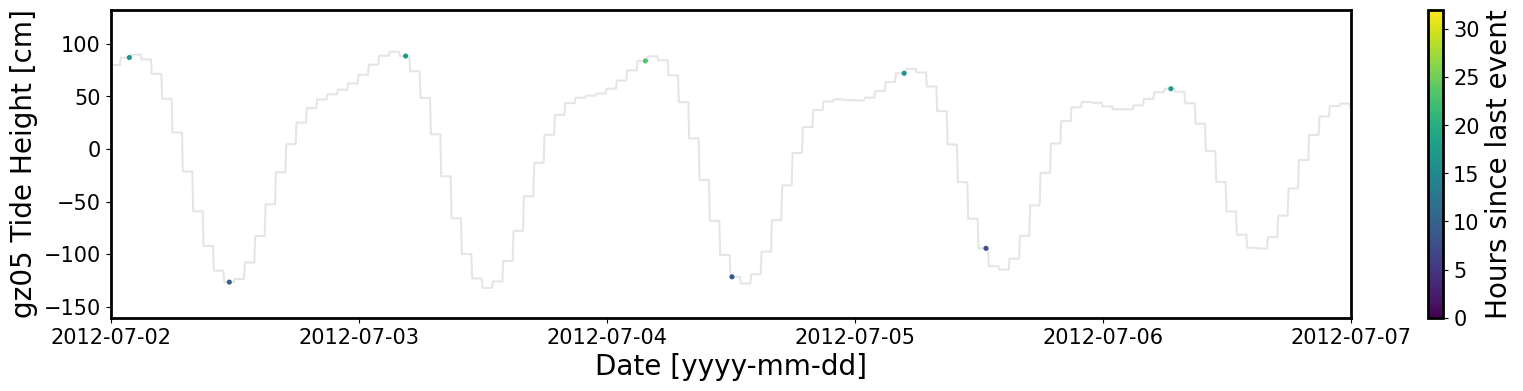

In [13]:
# Plot tides and events
fig, ax1 = plt.subplots(figsize=(20, 4))
ax1.plot(dates_timeseries, data["tides"], zorder=0, color="gray", alpha=0.2)
hr_since_last_event = [
    (a.days * 24 * 3600 + a.seconds) / 3600 for a in data["time_since_last_ev"]
]
masked_hr = np.ma.masked_greater(hr_since_last_event, 32)
masked_ev_time = np.ma.masked_where(np.ma.getmask(masked_hr), data["ev_time"])
masked_tide_ev_time = np.ma.masked_where(
    np.ma.getmask(masked_hr), data["tide_event_time"]
)
clr = ax1.scatter(
    data["ev_time"],
    data["tide_event_time"],
    c=masked_hr,
    vmin=0,
    vmax=32,
    zorder=1,
    cmap="viridis",
    s=7,
)
cbaramp = plt.colorbar(clr)
cbaramp.ax.tick_params(labelsize=15)
cbaramp.ax.set_ylabel("Hours since last event", size=20)
ax1.set_xlim(datetime.datetime(2012, 7, 2), datetime.datetime(2012, 7, 7))
ax1.set_xlabel("Date [yyyy-mm-dd]", size=20)
ax1.set_ylabel("gz05 Tide Height [cm]", size=20)
ax1.xaxis.set_tick_params(labelsize=15)
ax1.yaxis.set_tick_params(labelsize=15)

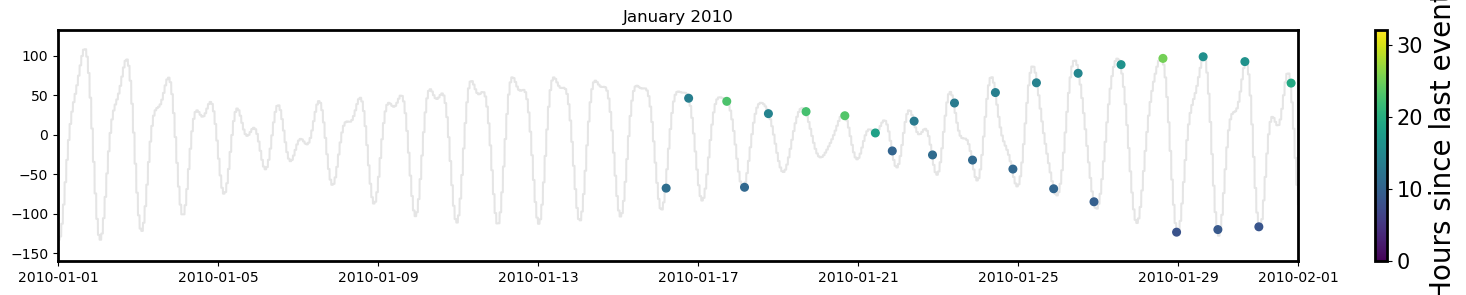

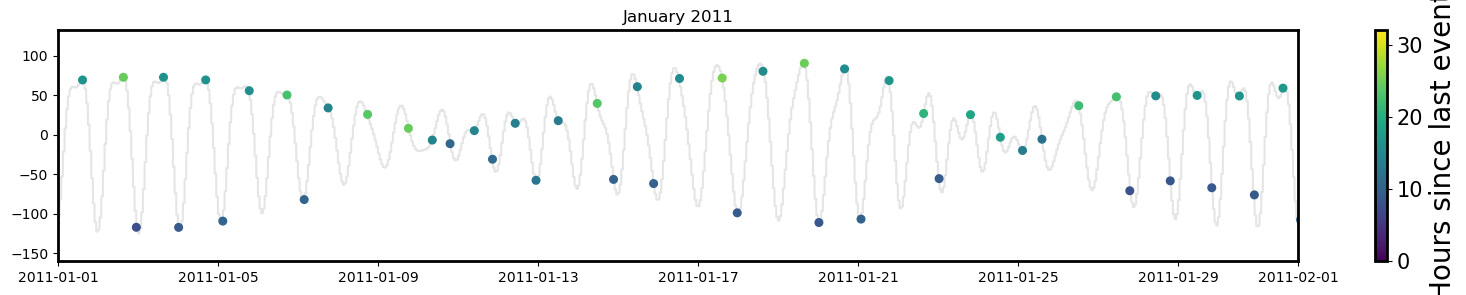

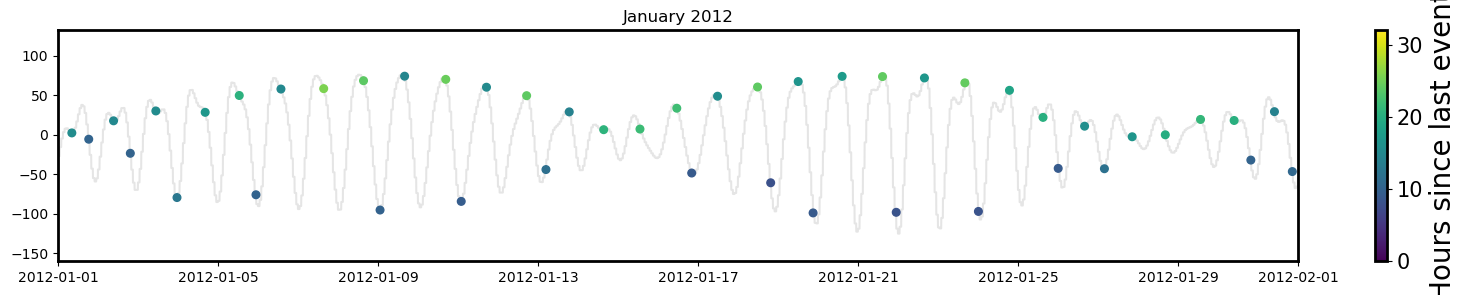

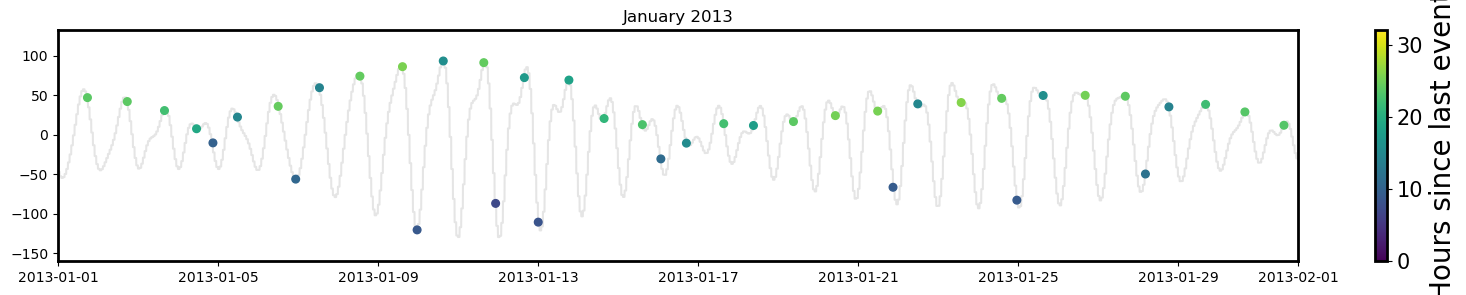

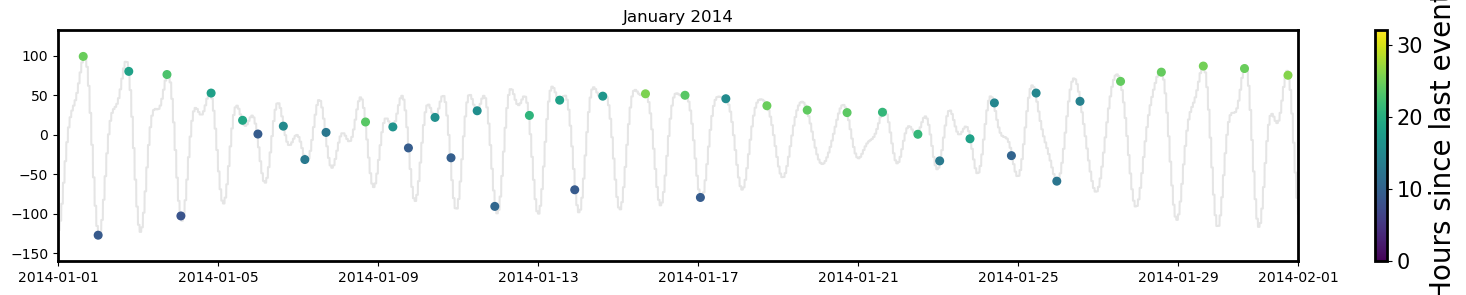

In [15]:
st_years = ["2010", "2011", "2012", "2013", "2014"]
ed_years = ["2011", "2012", "2013", "2014", "2015"]
for s_y, e_y in zip(st_years, ed_years):
    fig, ax1 = plt.subplots(figsize=(20, 3))
    ax1.plot(dates_timeseries, data["tides"], zorder=0, color="gray", alpha=0.2)
    hr_since_last_event = [
        (a.days * 24 * 3600 + a.seconds) / 3600 for a in data["time_since_last_ev"]
    ]
    masked_hr = np.ma.masked_greater(hr_since_last_event, 32)
    masked_ev_time = np.ma.masked_where(np.ma.getmask(masked_hr), data["ev_time"])
    masked_tide_ev_time = np.ma.masked_where(
        np.ma.getmask(masked_hr), data["tide_event_time"]
    )
    clr = ax1.scatter(
        data["ev_time"],
        data["tide_event_time"],
        c=masked_hr,
        vmin=0,
        vmax=32,
        zorder=1,
        cmap="viridis",
        s=30,
    )
    cbaramp = plt.colorbar(clr)
    cbaramp.ax.tick_params(labelsize=15)
    cbaramp.ax.set_ylabel("Hours since last event", size=20)
    ax1.set_xlim(datetime.datetime(int(s_y), 1, 1), datetime.datetime(int(s_y), 2, 1))
    plt.title(f"January {s_y}")

    """
    fig, ax1 = plt.subplots(figsize=(20,3))
    ax1.plot(dates_timeseries, data['tides'],zorder=0,color='gray',alpha=0.2)
    hr_since_last_event = [(a.days*24*3600 + a.seconds)/3600 for a in matt_data['time_since_last_ev']]
    masked_hr = np.ma.masked_greater(hr_since_last_event, 30)
    masked_ev_time = np.ma.masked_where(np.ma.getmask(masked_hr), matt_data['ev_time'])
    masked_tide_ev_time = np.ma.masked_where(np.ma.getmask(masked_hr), matt_data['tide_event_time'])
    clr = ax1.scatter(matt_data['ev_time'],matt_data['tide_event_time'],c=masked_hr,vmin=0,vmax=30,zorder=1,cmap='jet',s=6)
    cbaramp = plt.colorbar(clr)
    cbaramp.ax.tick_params(labelsize=15)
    cbaramp.ax.set_ylabel('Hours since last event',size=20)
    ax1.set_xlim(datetime.datetime(int(s_y),1,1),datetime.datetime(int(s_y),4,1))
    plt.title(f'SIEGFRIED {s_y}')
    """

In [24]:
# Send to csv for gmt plotting
df = pd.DataFrame({"x": masked_ev_time, "y": masked_tide_ev_time, "c": masked_hr})
df.to_csv("AllEventTideGMT.txt", columns=["x", "y", "c"], sep="\t", index=None)

In [26]:
print(len(dates_timeseries))
print(len(data["tides"]))
df2 = pd.DataFrame({"x": dates_timeseries, "y": data["tides"]})
df2.to_csv("AllEventBackgroundTideGMT.txt", columns=["x", "y"], sep="\t", index=None)

1576800
1576800
